# Notebook for analysing data generated from the Segway

The PID algorithm for equalising the motor speeds / distance travelled works well when a command to move forward and backward is given because in that case, the PWM output from motors doesn't fluctuate that much. But when the same logic is applied to the robot when it is simply balancing and an impulse is given, the logic simply fails. So to look into the problem, I collected data from the Segway to see how the PWM is varying in time when an impulse is given to it and what can be done about it.

## Plot Velocity data of individual motors

Lets us just plot the velocity data obtained from both motors. I have observed that the left motor is faster than right one when I push the robot and it ends up turning towards right when pushed in balancing mode.

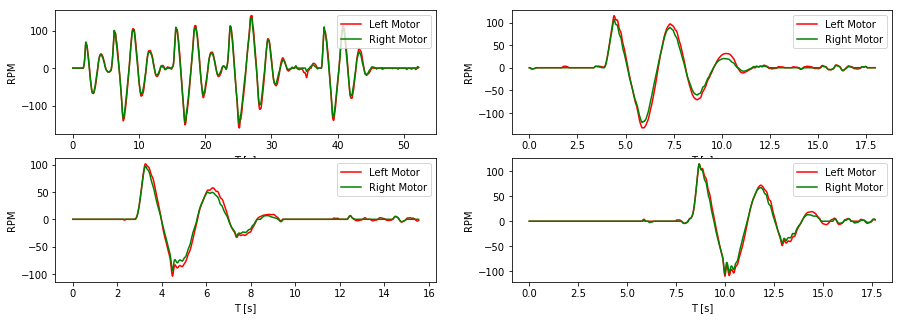

In [128]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


files = ["Set_"+str(i)+".txt" for i in range(1,5)] # Generate names of all the files
plt.figure(figsize = (15,5)) # Figure size

for j, file in enumerate(files):
    
    plt.subplot(2,2,j+1)
    
    df = pd.read_csv(file)
    t = [i*dt for i in range(len(df)) ] # Define time series

    # Add a new columns of difference of differences between left and right motor encoder counts i.e
    # (Encoder_L_now - Enc_L_Ref) - ((Encoder_R_now - Enc_R_Ref)

    df["DN(Lmot-Rmot)"] = df["DN_Lmot"] - df["DN_Rmot"] 
    
    plt.plot(t, 9.55 * df["Lmot_RPM"],'r', label = "Left Motor")# Convert speed from [rad/s] to [RPM]
    plt.plot(t, 9.55 * df["Rmot_RPM"], 'g',label = "Right Motor") 
    plt.legend(loc = "upper right")
    plt.xlabel("T [s]"); plt.ylabel("RPM")
#     sns.distplot(df1["Rmot_RPM"])
#     sns.distplot(df1["Lmot_RPM"])
#     plt.scatter(9.55 * df1["Lmot_RPM"], 9.55 * df1["Rmot_RPM"])
#     plt.xlabel("Left_Motor [RPM]"); plt.ylabel("Right_Motor [RPM]")

It can be clearly observed that the data supports the observation as well. The Left motor RPM exceeds the right motor RPM at certain instants.

# Plot all the variables in the dataset

Text(0.5, 0, 'T [s]')

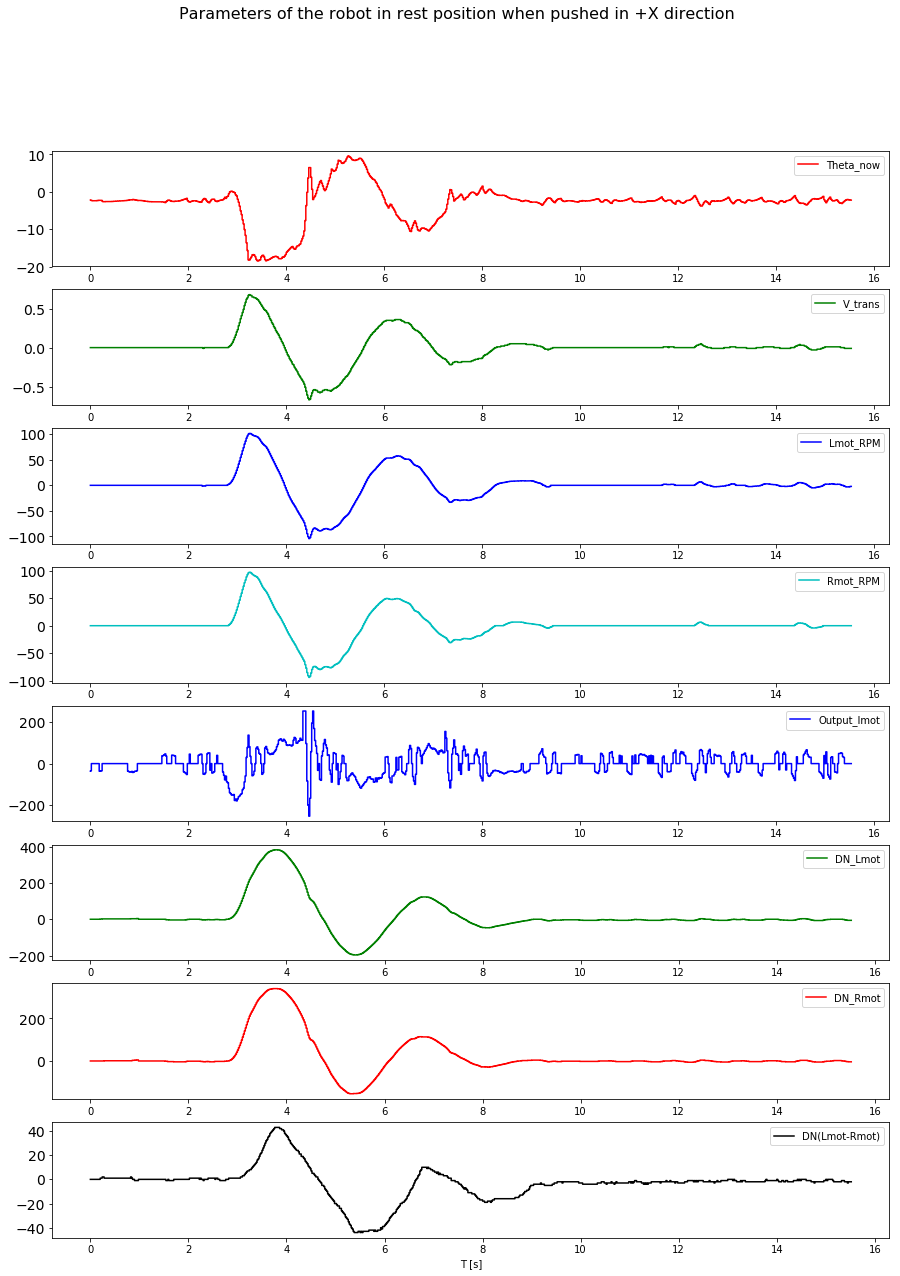

In [129]:
df1 = pd.read_csv("Set_3.txt")
# Add a new columns of difference of differences between left and right motor encoder counts i.e
# (Encoder_L_now - Enc_L_Ref) - ((Encoder_R_now - Enc_R_Ref)
df1["DN(Lmot-Rmot)"] = df1["DN_Lmot"] - df1["DN_Rmot"] 
df1.drop(labels = "Output_rmot", axis = 1, inplace = True)

cols2plot = df1.columns

# cols2plot = ['Theta_now','V_trans','Output_lmot','DN(Lmot-Rmot)']
# units = ["Tilt Angle [Deg]", "Speed [m/s]", "PWM", "$\Delta$ Ticks(L-R)", "Ticks", "Ticks"]

clr = ['r','g','b','c','b','g', 'r', 'k', 'm']

dt = 0.02 # Sampling time [s]

t = [i*dt for i in range(len(df1)) ]

k1 = 0; k2 = len(df1); # To select portions of the data 

plt.figure(figsize = (15,20))
plt.suptitle("Parameters of the robot in rest position when pushed in +X direction", fontsize = 16)

for i,col in zip(range(len(cols2plot)), cols2plot):
    plt.subplot(len(cols2plot),1,i+1)
    if (col == "Lmot_RPM" or col == "Rmot_RPM"):
        plt.step(t[k1:k2], 9.55 * df1.loc[k1:k2, col], clr[i], label = col) # Convert rad/s to RPM
        plt.legend(loc = "upper right")
        plt.yticks(fontsize = 14)
    else:
        plt.step(t[k1:k2], df1.loc[k1:k2, col], clr[i], label = col)
        plt.legend(loc = "upper right")
    #     plt.ylabel(unit, fontsize = 14)
        plt.yticks(fontsize = 14)

plt.xlabel("T [s]")


The output PWM to Left and right motors (figure 5 Output_lmot, only left motor is plotted because the PWM values are same for both the motors) show that the PWM is quite jittery. So for the time being, the PID controller is only applied when the command to go forward and backward is given. To correct for the speed differences during balancing mode when an external impulse is given, the Output to the left motor is **scaled by a factor 0.93 (Output_lmot*=0.93 in the code)**. This scaling seems to reduce the speed differences between the motors but is not very accurate.

# Frequency of oscillation of the robot when pushed by an external impulse

In order to calculate the frequency of oscillation of the robot, we can use fourier transform of the velocity. By changing the dataset name, we can see that with the current PID gains, the oscillation frequency is **0.25** Hz

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 9 Text xticklabel objects>)

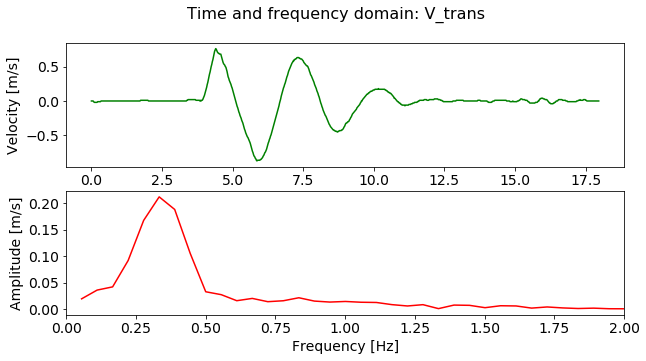

In [130]:
df2 = pd.read_csv("Set_2.txt")
t1 = [i*dt for i in range(len(df2)) ]
a = df2["V_trans"]
y = np.fft.fft(a) # Getting complex coefficients of the data points in frequency domain
C = np.fft.fftfreq(len(t1),dt)# Getting the frequency bins [Hz]

plt.figure(figsize = (10,5))
plt.suptitle("Time and frequency domain: V_trans", fontsize = 16)
plt.subplot(211)
plt.plot(t1,a, "g")
plt.xlabel("T [s]");plt.ylabel("Velocity [m/s]", fontsize = 14); plt.yticks(fontsize = 14);plt.xticks(fontsize = 14)

plt.subplot(212)
plt.plot(C[C>0],abs(y[C>0])/(0.5*len(y)), "r")
plt.xlim(0,2)
plt.xlabel("Frequency [Hz]", fontsize = 14); plt.xticks(fontsize = 14)
plt.ylabel("Amplitude [m/s]",fontsize = 14);  plt.yticks(fontsize = 14); plt.xticks(fontsize = 14)
